In [2]:
import os
import pandas as pd
import numpy as np
import anndata
import time
import matplotlib.pyplot as plt
import json
import requests
import pickle
import gzip as gz
import re

import sys
sys.path.insert(1, '/home/jw3514/Work/CellType_Psy/src/')
from CellType_PSY import *

os.chdir("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/")
print(f"Current working directory: {os.getcwd()}")



Current working directory: /home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas


In [3]:
CellTypesDF = pd.read_csv("dat/CellTypeHierarchy.csv")
Class2Cluster = {}
Subclass2Cluster = {}
for i, row in CellTypesDF.iterrows():
    _cluster, _class, _subclass, _supertype = row
    if _class not in Class2Cluster:
        Class2Cluster[_class] = []
    if _subclass not in Subclass2Cluster:
        Subclass2Cluster[_subclass] = []
    Class2Cluster[_class].append(_cluster)
    Subclass2Cluster[_subclass].append(_cluster)
    
ClusterAnn = pd.read_excel("/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/SuppTables/41586_2023_6812_MOESM8_ESM.xlsx",
                          sheet_name = "cluster_annotation", index_col="cluster_id_label")


## Test Split Cluster

In [4]:
cell_extended = pd.read_csv("dat/cell_metadata_with_cluster_annotation.csv")

/tmp/ipykernel_813332/2665016588.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  cell_extended = pd.read_csv("dat/cell_metadata_with_cluster_annotation.csv")


In [5]:
ENSMUSG2HumanEntrez = json.load(open("dat/ENSMUSG2HumanEntrez.json", 'r'))
def ExpMatConvertEntrez(CombineMat, ENSMUSG2HumanEntrez):
    dat_rows = []
    index = []
    for ensg, row in CombineMat.iterrows():
        if ensg in ENSMUSG2HumanEntrez:
            for entrez in ENSMUSG2HumanEntrez[ensg]:
                index.append(entrez)
                dat_rows.append(row)
    ExpDF_humanEntrez = pd.DataFrame(data=dat_rows, index=index, columns=CombineMat.columns.values)
    ExpDF_humanEntrezDedup = ExpDF_humanEntrez[~ExpDF_humanEntrez.index.duplicated(keep='first')]
    return ExpDF_humanEntrezDedup

In [6]:
feature_matrix_label = cell_extended["feature_matrix_label"].unique()
feature_matrix_label_v3 = [x for x in feature_matrix_label if 'v3' in x]
feature_matrix_label_v2 = [x for x in feature_matrix_label if 'v2' in x]

In [7]:
print(feature_matrix_label_v2)
print(feature_matrix_label_v3)

['WMB-10Xv2-HPF', 'WMB-10Xv2-Isocortex-1', 'WMB-10Xv2-HY', 'WMB-10Xv2-TH', 'WMB-10Xv2-OLF', 'WMB-10Xv2-CTXsp', 'WMB-10Xv2-MB', 'WMB-10Xv2-Isocortex-2', 'WMB-10Xv2-Isocortex-3', 'WMB-10Xv2-Isocortex-4']
['WMB-10Xv3-HPF', 'WMB-10Xv3-Isocortex-1', 'WMB-10Xv3-PAL', 'WMB-10Xv3-STR', 'WMB-10Xv3-CTXsp', 'WMB-10Xv3-HY', 'WMB-10Xv3-OLF', 'WMB-10Xv3-TH', 'WMB-10Xv3-P', 'WMB-10Xv3-MB', 'WMB-10Xv3-MY', 'WMB-10Xv3-CB', 'WMB-10Xv3-Isocortex-2']


In [27]:
#RAW_EXP_DIR = "/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/abc_download_root/expression_matrices/WMB-10Xv3/20230630/"
RAW_EXP_DIR = "/mnt/data0/AllenMouseSC/abc_download_root/expression_matrices/WMB-10Xv3/20230630"
feature2Fil_10xV3 = {}
for feature in feature_matrix_label_v3:
    Adat = anndata.read_h5ad(RAW_EXP_DIR + "{}-log2.h5ad".format(feature), backed='r')
    feature2Fil_10xV3[feature] = Adat

In [8]:
RAW_EXP_DIR = "/mnt/data0/AllenMouseSC/abc_download_root/expression_matrices/WMB-10Xv2/20230630"
feature2Fil_10xV2 = {}
for feature in feature_matrix_label_v2:
    Adat = anndata.read_h5ad(RAW_EXP_DIR + "{}-log2.h5ad".format(feature), backed='r')
    feature2Fil_10xV2[feature] = Adat

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/mnt/data0/AllenMouseSC/abc_download_root/expression_matrices/WMB-10Xv2/20230630WMB-10Xv2-HPF-log2.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [28]:
#### Test on one cluster

In [5]:
cluster = "2691 RE-Xi Nox4 Glut_1"
cluster_meta = cell_extended[cell_extended["cluster"]==cluster]
tmp_value_counts = cluster_meta["feature_matrix_label"].value_counts()

In [6]:
tmp_value_counts

WMB-10Xv3-TH    154
WMB-10Xv2-TH    140
WMB-10Xv2-HY     26
WMB-10Xv3-HY     24
Name: feature_matrix_label, dtype: int64

In [34]:
CT_V3_features = [x for x in tmp_value_counts.index.values if "v3" in x]

In [35]:
CT_V3_features

['WMB-10Xv3-TH', 'WMB-10Xv3-HY']

In [39]:
Cluster_Barcodes = cell_extended[cell_extended["cluster"]==cluster]["cell_barcode"].values
len(Cluster_Barcodes)

344

In [43]:
Cluster_GeneXCell_DFs = []
for feature in CT_V3_features:
    print(feature)
    feature_h5d = feature2Fil_10xV3[feature]
    
    submat_cluster = feature_h5d[feature_h5d.obs["cell_barcode"].isin(Cluster_Barcodes)]
    submat_cluster = submat_cluster.to_df()
    submat_cluster = submat_cluster.transpose()
    submat_cluster = ExpMatConvertEntrez(submat_cluster, ENSMUSG2HumanEntrez)
    Cluster_GeneXCell_DFs.append(submat_cluster)

WMB-10Xv3-TH
WMB-10Xv3-HY


In [45]:
concatenated_df = pd.concat(Cluster_GeneXCell_DFs, axis=1)

In [46]:
concatenated_df

,GATAGAACAGTTCACA-319_A06,TTCTTGATCACAAGGG-286_B06,ACTTCCGAGCCTCACG-290_B01,AAAGAACGTGCAAGAC-581_B01,GTAATCGAGAATCGCG-286_B06,TGTTTGTGTGAATGTA-292_B03,CATACTTGTCGATTCA-286_B06,ATTACCTGTAATGTGA-286_B06,CGCAGGTCAACTGTGT-286_B06,AGATAGAAGATAGCTA-290_B01,...,TCCTAATGTGCCCACA-354_A06,TCGAACACATAACGGG-354_A06,TCTCCGATCCAGCACG-345_D05,TGTGTGACAACATCGT-354_A06,CCAATTTTCATCGCAA-392_A04,TCGATTTAGCAACAGC-577_A03,TCGTCCAAGCCTCATA-577_A03,ACGGTCGAGCATTGAA-326_D05,ACTATCTGTACCGGCT-462_B04,TGCTCGTGTTGCATGT-577_A03
114786,9.733018,9.634921,7.977592,10.397364,9.719309,10.026166,9.012802,9.286551,10.080962,9.548250,...,10.306938,9.246920,10.130755,9.487776,0.000000,10.003034,0.000000,0.000000,0.000000,0.000000
6101,0.000000,0.000000,0.000000,0.000000,0.000000,5.206414,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,5.135098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
64321,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.039595
29088,0.000000,5.347064,0.000000,0.000000,0.000000,6.186743,5.054099,0.000000,4.775729,0.000000,...,0.000000,4.658955,0.000000,0.000000,7.334132,6.319367,0.000000,0.000000,7.593100,0.000000
10434,0.000000,5.347064,0.000000,0.000000,5.360821,0.000000,5.054099,0.000000,4.775729,5.765731,...,5.432703,4.658955,0.000000,5.135098,0.000000,7.310306,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,8.542550,7.902183,8.239672,8.683599,7.916226,6.765089,8.015593,8.650404,8.049461,8.742340,...,7.407431,7.777204,6.022550,8.268061,7.334132,8.305754,7.922808,8.928907,10.171823,8.039595
4538,11.404279,11.377809,10.405880,12.149174,10.233369,10.297231,10.368650,11.062521,11.026549,10.987606,...,10.128119,10.645982,9.587025,10.486772,11.717909,12.430732,12.917037,10.734146,12.673293,12.319786
4540,9.126223,8.899164,8.461382,9.398433,5.360821,7.979882,6.609817,8.067235,9.046736,8.066288,...,8.211140,8.065514,7.331100,7.423803,7.334132,9.111154,10.917597,7.931864,10.171823,8.039595
4541,7.064071,5.347064,0.000000,7.878873,5.360821,0.000000,5.054099,6.492990,4.775729,6.752411,...,5.432703,5.630115,5.044573,7.685436,7.334132,7.892236,8.919832,0.000000,8.589359,0.000000


In [49]:
cluster_clean_name = re.sub(r'\W+', '_', cluster)

In [51]:
cluster_clean_name

'2691_RE_Xi_Nox4_Glut_1'

In [53]:
SaveDIR = "/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/Cluster_GeneXCell/"

In [54]:
concatenated_df.to_csv("{}/{}.GeneXCell.csv".format(SaveDIR, cluster_clean_name))

In [55]:
def ExtractGeneXcellForCluster(cluster, cell_extended=cell_extended, ):
    cluster_meta = cell_extended[cell_extended["cluster"]==cluster]
    tmp_value_counts = cluster_meta["feature_matrix_label"].value_counts()
    CT_V3_features = [x for x in tmp_value_counts.index.values if "v3" in x]
    Cluster_Barcodes = cell_extended[cell_extended["cluster"]==cluster]["cell_barcode"].values
    print("CT: {} Ncells: {}".format(cluster, len(Cluster_Barcodes)))
    Cluster_GeneXCell_DFs = []
    for feature in CT_V3_features:
        feature_h5d = feature2Fil_10xV3[feature]
        submat_cluster = feature_h5d[feature_h5d.obs["cell_barcode"].isin(Cluster_Barcodes)]
        submat_cluster = submat_cluster.to_df()
        submat_cluster = submat_cluster.transpose()
        submat_cluster = ExpMatConvertEntrez(submat_cluster, ENSMUSG2HumanEntrez)
        Cluster_GeneXCell_DFs.append(submat_cluster)
    cluster_clean_name = re.sub(r'\W+', '_', cluster)
    concatenated_df = pd.concat(Cluster_GeneXCell_DFs, axis=1)
    concatenated_df.to_csv("{}/{}.GeneXCell.csv".format(SaveDIR, cluster_clean_name))

In [56]:
cluster = "2691 RE-Xi Nox4 Glut_1"
ExtractGeneXcellForCluster(cluster, cell_extended=cell_extended, )

CT: 2691 RE-Xi Nox4 Glut_1 Ncells: 344


In [57]:
for cluster in ClusterAnn.index.values:
    print(cluster)

0001 CLA-EPd-CTX Car3 Glut_1
0002 CLA-EPd-CTX Car3 Glut_1
0003 CLA-EPd-CTX Car3 Glut_1
0004 CLA-EPd-CTX Car3 Glut_1
0005 CLA-EPd-CTX Car3 Glut_2
0006 IT EP-CLA Glut_1
0007 IT EP-CLA Glut_1
0008 IT EP-CLA Glut_1
0009 IT EP-CLA Glut_1
0010 IT EP-CLA Glut_1
0011 IT EP-CLA Glut_1
0012 IT EP-CLA Glut_1
0013 IT EP-CLA Glut_2
0014 IT EP-CLA Glut_2
0015 IT EP-CLA Glut_2
0016 IT EP-CLA Glut_2
0017 IT EP-CLA Glut_2
0018 IT EP-CLA Glut_3
0019 IT EP-CLA Glut_3
0020 IT EP-CLA Glut_3
0021 IT EP-CLA Glut_4
0022 IT EP-CLA Glut_4
0023 L5/6 IT TPE-ENT Glut_1
0024 L5/6 IT TPE-ENT Glut_1
0025 L5/6 IT TPE-ENT Glut_1
0026 L5/6 IT TPE-ENT Glut_2
0027 L5/6 IT TPE-ENT Glut_2
0028 L5/6 IT TPE-ENT Glut_2
0029 L5/6 IT TPE-ENT Glut_3
0030 L5/6 IT TPE-ENT Glut_4
0031 L5/6 IT TPE-ENT Glut_5
0032 L5/6 IT TPE-ENT Glut_6
0033 L6 IT CTX Glut_1
0034 L6 IT CTX Glut_1
0035 L6 IT CTX Glut_1
0036 L6 IT CTX Glut_1
0037 L6 IT CTX Glut_1
0038 L6 IT CTX Glut_2
0039 L6 IT CTX Glut_2
0040 L6 IT CTX Glut_2
0041 L6 IT CTX Glut_2
004

4439 SPVI-SPVC Tlx3 Ebf3 Glut_5
4440 SPVI-SPVC Tlx3 Ebf3 Glut_5
4441 SPVI-SPVC Tlx3 Ebf3 Glut_6
4442 SPVI-SPVC Tlx3 Ebf3 Glut_6
4443 SPVI-SPVC Tlx3 Ebf3 Glut_6
4444 SPVI-SPVC Tlx3 Ebf3 Glut_6
4445 SPVI-SPVC Tlx3 Ebf3 Glut_7
4446 SPVI-SPVC Tlx3 Ebf3 Glut_7
4447 SPVI-SPVC Tlx3 Ebf3 Glut_7
4448 CU-ECU-SPVI Foxb1 Glut_1
4449 CU-ECU-SPVI Foxb1 Glut_1
4450 CU-ECU-SPVI Foxb1 Glut_1
4451 CU-ECU-SPVI Foxb1 Glut_1
4452 CU-ECU-SPVI Foxb1 Glut_1
4453 CU-ECU-SPVI Foxb1 Glut_1
4454 CU-ECU-SPVI Foxb1 Glut_1
4455 CU-ECU-SPVI Foxb1 Glut_1
4456 CU-ECU-SPVI Foxb1 Glut_1
4457 CU-ECU-SPVI Foxb1 Glut_1
4458 CU-ECU-SPVI Foxb1 Glut_1
4459 CU-ECU-SPVI Foxb1 Glut_1
4460 CU-ECU-SPVI Foxb1 Glut_1
4461 CU-ECU-SPVI Foxb1 Glut_1
4462 CU-ECU-SPVI Foxb1 Glut_1
4463 CU-ECU-SPVI Foxb1 Glut_1
4464 CU-ECU-SPVI Foxb1 Glut_1
4465 CU-ECU-SPVI Foxb1 Glut_1
4466 CU-ECU-SPVI Foxb1 Glut_1
4467 CU-ECU-SPVI Foxb1 Glut_1
4468 CU-ECU-SPVI Foxb1 Glut_2
4469 CU-ECU-SPVI Foxb1 Glut_2
4470 CU-ECU-SPVI Foxb1 Glut_2
4471 CU-ECU-SPVI Foxb1

In [58]:
100 * 5000 / 1000

500.0

## Aggregate to CT LogUMI

In [59]:
DatDIR = "/home/jw3514/Work/data/Allen_Mouse_Brain_Cell_Atlas/Cluster_GeneXCell_UMI"

In [60]:
test_genexcell = pd.read_csv("{}/0001_CLA_EPd_CTX_Car3_Glut_1.GeneXCell.csv".format(DatDIR), index_col=0)

In [62]:
test_genexcell_log = np.log2(test_genexcell+1)

In [64]:
Gene_Cluster_Mean = test_genexcell_log.mean(axis=1)

In [74]:
Total_UMI = test_genexcell_log.sum(axis=0)

(array([  5.,  27.,  58.,  61.,  85., 140., 114.,  54.,  13.,   1.]),
 array([ 1260.22277333,  3767.23064583,  6274.23851832,  8781.24639081,
        11288.2542633 , 13795.2621358 , 16302.27000829, 18809.27788078,
        21316.28575328, 23823.29362577, 26330.30149826]),
 <BarContainer object of 10 artists>)

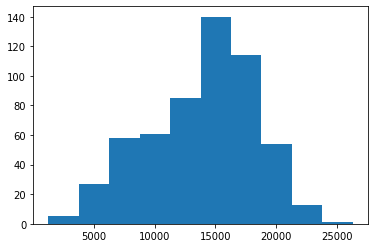

In [75]:
plt.hist(Total_UMI)

In [153]:
def processCluster(cluster, DatDIR):
    cluster_clean_name = re.sub(r'\W+', '_', cluster)
    test_genexcell = pd.read_csv("{}/{}.GeneXCell.csv".format(DatDIR, cluster_clean_name), index_col=0)
    test_genexcell_log = np.log2(test_genexcell+1)
    Gene_Cluster_Mean = test_genexcell_log.mean(axis=1)
    Gene_Cluster_Total = test_genexcell_log.sum(axis=1)
    Total_UMI = test_genexcell_log.sum(axis=0)
    return Gene_Cluster_Mean, Gene_Cluster_Total, Total_UMI

In [154]:
clusters = ClusterAnn.head(2).index.values

In [155]:
results = [processCluster(cluster, DatDIR) for cluster in clusters]

In [159]:
def CollectRes(clusters, results):
    Indv_cluster_means = []
    Indv_cluster_total_UMIs = []
    Gene_Total_Exp = np.zeros(len(results[0][1]))
    for cluster, res in zip(clusters, results):
        gene_mean_logUMI = res[0]
        gene_mean_logUMI.name = cluster
        gene_total_logUMI = res[1]
        Gene_Total_Exp += gene_total_logUMI
        cell_depth = res[2].values
        Indv_cluster_means.append(gene_mean_logUMI)
        Indv_cluster_total_UMIs.append(cell_depth)
        
    # Make and save cluster Exp Mat
    Cluster_Exp_DF = pd.concat(Indv_cluster_means, axis=1)
    Cluster_Exp_DF.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/cluster_MeanLogUMI.csv")
    
    # Save Cell depth for each clusters
    with open("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/clusters_CellDepth.npy", 'wb') as f:
        np.save(f, Indv_cluster_total_UMIs)
        
    # Calculate Expression Matching quntiles
    Gene_Total_Exp = Gene_Total_Exp/Total_N_Cells
    Gene_Total_Exp.name="PerCellExp"
    Gene_Total_Exp_DF = pd.DataFrame(data=Gene_Total_Exp)
    Gene_Total_Exp_DF = Gene_Total_Exp_DF.sort_values("PerCellExp")
    Gene_Total_Exp_DF["Rank"] = [1+x for x in range(Gene_Total_Exp_DF.shape[0])] # compute Rank
    Gene_Total_Exp_DF["quantile"] = Gene_Total_Exp_DF["Rank"]/Gene_Total_Exp_DF.shape[0]
    Gene_Total_Exp_DF.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/ABC_LogUMI.Match.10xV3.csv")

In [157]:
CollectRes(clusters, results)

/home/jw3514/anaconda3/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


#### Process some big CT

In [163]:
def processCluster2(cluster, DatDIR):
    
    cluster_clean_name = re.sub(r'\W+', '_', cluster)
    print("Reading file")
    test_genexcell = pd.read_csv("{}/{}.GeneXCell.csv".format(DatDIR, cluster_clean_name), index_col=0)
    print("calculating mean")
    test_genexcell_log = np.log2(test_genexcell+1)
    Gene_Cluster_Mean = test_genexcell_log.mean(axis=1)
    Gene_Cluster_Mean.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/SplitCTs/{}.csv".format(cluster_clean_name))
    return 

In [ ]:
def processClusterV2(cluster, DatDIR):
    
    cluster_clean_name = re.sub(r'\W+', '_', cluster)
    print("Reading file")
    test_genexcell = csv.reader("{}/{}.GeneXCell.csv".format(DatDIR, cluster_clean_name), index_col=0)
    print("calculating mean")
    test_genexcell_log = np.log2(test_genexcell+1)
    Gene_Cluster_Mean = test_genexcell_log.mean(axis=1)
    Gene_Cluster_Mean.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/SplitCTs/{}.csv".format(cluster_clean_name))
    return 

In [201]:
cluster = "1082 LSX Nkx2-1 Gaba_2"

In [202]:
cluster_clean_name = re.sub(r'\W+', '_', cluster)
with open("{}/{}.GeneXCell.csv".format(DatDIR, cluster_clean_name)) as csvfile:
    gene_dat = []
    gene_index = []
    reader = csv.reader(csvfile)
    head = next(reader)
    for row in reader:
        gene_index.append(int(row[0]))
        log2UMI = np.log2(np.array([float(x) for x in row[1:]]) + 1)
        gene_dat.append(log2UMI.mean())
    Gene_Cluster_Mean = pd.Series(data=gene_dat, index=gene_index)
    Gene_Cluster_Mean.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/SplitCTs/{}.csv".format(cluster_clean_name))

In [178]:
Gene_Cluster_Mean

114786    3.756001
6101      0.009227
64321     0.025444
29088     0.514703
10434     0.748046
            ...   
4539      2.423110
4538      5.438423
4540      3.140518
4541      0.801797
4519      4.813161
Length: 17938, dtype: float64

In [179]:
Gene_Cluster_Mean.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/SplitCTs/test.{}.csv".format(cluster_clean_name))

In [227]:
## Aggregate splited files into one matrix

Indv_cluster_means = []
Indv_cluster_total_UMIs = []
Gene_Total_Exp = []
Total_N_Cells = 0
for cluster, row in ClusterAnn.iterrows():
    cluster_v3_cell_counts = row["v3.size"]
    if cluster_v3_cell_counts == 0:
        continue
    cluster_clean_name = re.sub(r'\W+', '_', cluster)  
    gene_mean_logUMI = pd.read_csv(("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/SplitCTs/{}.csv".format(cluster_clean_name)),
                                  index_col=0)
    gene_mean_logUMI.rename(columns={"0": cluster}, inplace=True)
    if len(gene_mean_logUMI) != 17938:
        print(cluster, cluster_clean_name, len(gene_mean_logUMI))
    Total_N_Cells += cluster_v3_cell_counts
    #print(cluster_v3_cell_counts)
    if len(Gene_Total_Exp) == 0:
        Gene_Total_Exp = gene_mean_logUMI * cluster_v3_cell_counts
    else:
        Gene_Total_Exp += gene_mean_logUMI * cluster_v3_cell_counts
    gene_mean_logUMI.name = cluster
    Indv_cluster_means.append(gene_mean_logUMI)

# Make and save cluster Exp Mat
Cluster_Exp_DF = pd.concat(Indv_cluster_means, axis=1)
Cluster_Exp_DF.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/cluster_MeanLogUMI.csv")

In [225]:
gene_mean_logUMI.rename(columns={"0": cluster}, inplace=True)

In [226]:
gene_mean_logUMI

,5322 T cells NN_4
114786,1.085688
6101,0.000000
64321,0.036673
29088,0.244084
10434,0.430567
...,...
4539,1.843688
4538,4.457803
4540,2.333779
4541,0.704805


In [ ]:
# Calculate Expression Matching quntiles
Gene_Total_Exp = Gene_Total_Exp/Total_N_Cells
Gene_Total_Exp.name="PerCellExp"
Gene_Total_Exp_DF = pd.DataFrame(data=Gene_Total_Exp)
Gene_Total_Exp_DF = Gene_Total_Exp_DF.sort_values("PerCellExp")
Gene_Total_Exp_DF["Rank"] = [1+x for x in range(Gene_Total_Exp_DF.shape[0])] # compute Rank
Gene_Total_Exp_DF["quantile"] = Gene_Total_Exp_DF["Rank"]/Gene_Total_Exp_DF.shape[0]
Gene_Total_Exp_DF.to_csv("/home/jw3514/Work/CellType_Psy/AllenBrainCellAtlas/dat/SC_UMI_Mats/ABC_LogUMI.Match.10xV3.csv")